In [ ]:
# notebook to make cool plot of the May 9 event

In [2]:
%matplotlib widget
import numpy as np
import obspy
import matplotlib.pyplot as plt
from matplotlib.widgets import Button
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogFormatterMathtext
from scipy.signal import spectrogram
import datetime

In [ ]:
# set path and data parameters
path = "/media/Data/Data/PIG/"
stat = "PIG*"
chans = "HH*"

# set day of interest
year = "2012"
month = "05"
day = "09"

# read in traces without instrument response removed
files = path + "MSEED/raw/" + stat + "/" + chans + "/*" + chans + "__" + year + month + day + "T000000Z__" + "*"

In [ ]:
# read in raw data
st_raw = obspy.read(files)

# basic preprocessing
st_raw.detrend("demean")
st_raw.detrend("linear")
st_raw.taper(max_percentage=0.00025, max_length=20.)

# set path to XML response file
pathXML = path + "XML/" + chans + "/*" + stat + ".xml"
inv = obspy.read_inventory(pathXML)

# remove response
st_100s = st_raw.copy()
st_1000s = st_raw.copy()
st_100s.remove_response(inventory=inv,pre_filt=[0.005,0.01,45,50],output="VEL")
st_1000s.remove_response(inventory=inv,pre_filt=[0.0005,0.001,45,50],output="VEL")

# save outputs
st_raw.write("data/may_9_velocity_raw.MSEED")
st_100s.write("data/may_9_velocity_100s.MSEED")
st_1000s.write("data/may_9_velocity_1000s.MSEED")

# downsample so plotting isn't horribly slow
st_raw.resample(1)
st_100s.resample(1)
st_1000s.resample(1)

# save outputs
st_raw.write("data/may_9_velocity_raw_1Hz.MSEED")
st_100s.write("data/may_9_velocity_100_1Hzs.MSEED")
st_1000s.write("data/may_9_velocity_1000s_1Hz.MSEED")

In [3]:
# get data
st_raw = obspy.read("data/may_9_velocity_raw_1Hz.MSEED")
st_100s = obspy.read("data/may_9_velocity_100s_1Hz.MSEED")
st_1000s = obspy.read("data/may_9_velocity_1000s_1Hz.MSEED")

# get response
inv = obspy.read_inventory("data/*.xml")

In [6]:
class metadata:
    station = "PIG2"
    channel = "HHZ"
    
    def select_channel(self,channel,column):
        def clicked(event):
            self.channel = channel
            # plot each trace
            ax[1][column].get_lines()[0].set_ydata(st_raw.select(station=self.station,channel=self.channel)[0].data[:trace_length]*1000)
            ax[2][column].get_lines()[0].set_ydata(st_100s.select(station=self.station,channel=self.channel)[0].data[:trace_length]*1000)
            ax[3][column].get_lines()[0].set_ydata(st_1000s.select(station=self.station,channel=self.channel)[0].data[:trace_length]*1000)

            ax[0][column].set(title=self.station+" "+self.channel+"\nInstrument Response")
            for axis in ax.transpose()[column][1:]:
                axis.relim()
                axis.autoscale()
                axis.set_xlim([t[0],t[-1]])
            plt.draw()
        return clicked
    
    def select_station(self,station,column):
        def clicked(event):
            self.station = station
            ax[1][column].get_lines()[0].set_ydata(st_raw.select(station=self.station,channel=self.channel)[0].data[:trace_length]*1000)
            ax[2][column].get_lines()[0].set_ydata(st_100s.select(station=self.station,channel=self.channel)[0].data[:trace_length]*1000)
            ax[3][column].get_lines()[0].set_ydata(st_1000s.select(station=self.station,channel=self.channel)[0].data[:trace_length]*1000)
            
            ax[0][column].set(title=self.station+" "+self.channel+"\nInstrument Response")
            for axis in ax.transpose()[column][1:]:
                axis.relim()
                axis.autoscale()
                axis.set_xlim([t[0],t[-1]])
            plt.draw()
        return clicked

/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:33: RuntimeWarning: divide by zero encountered in true_divide


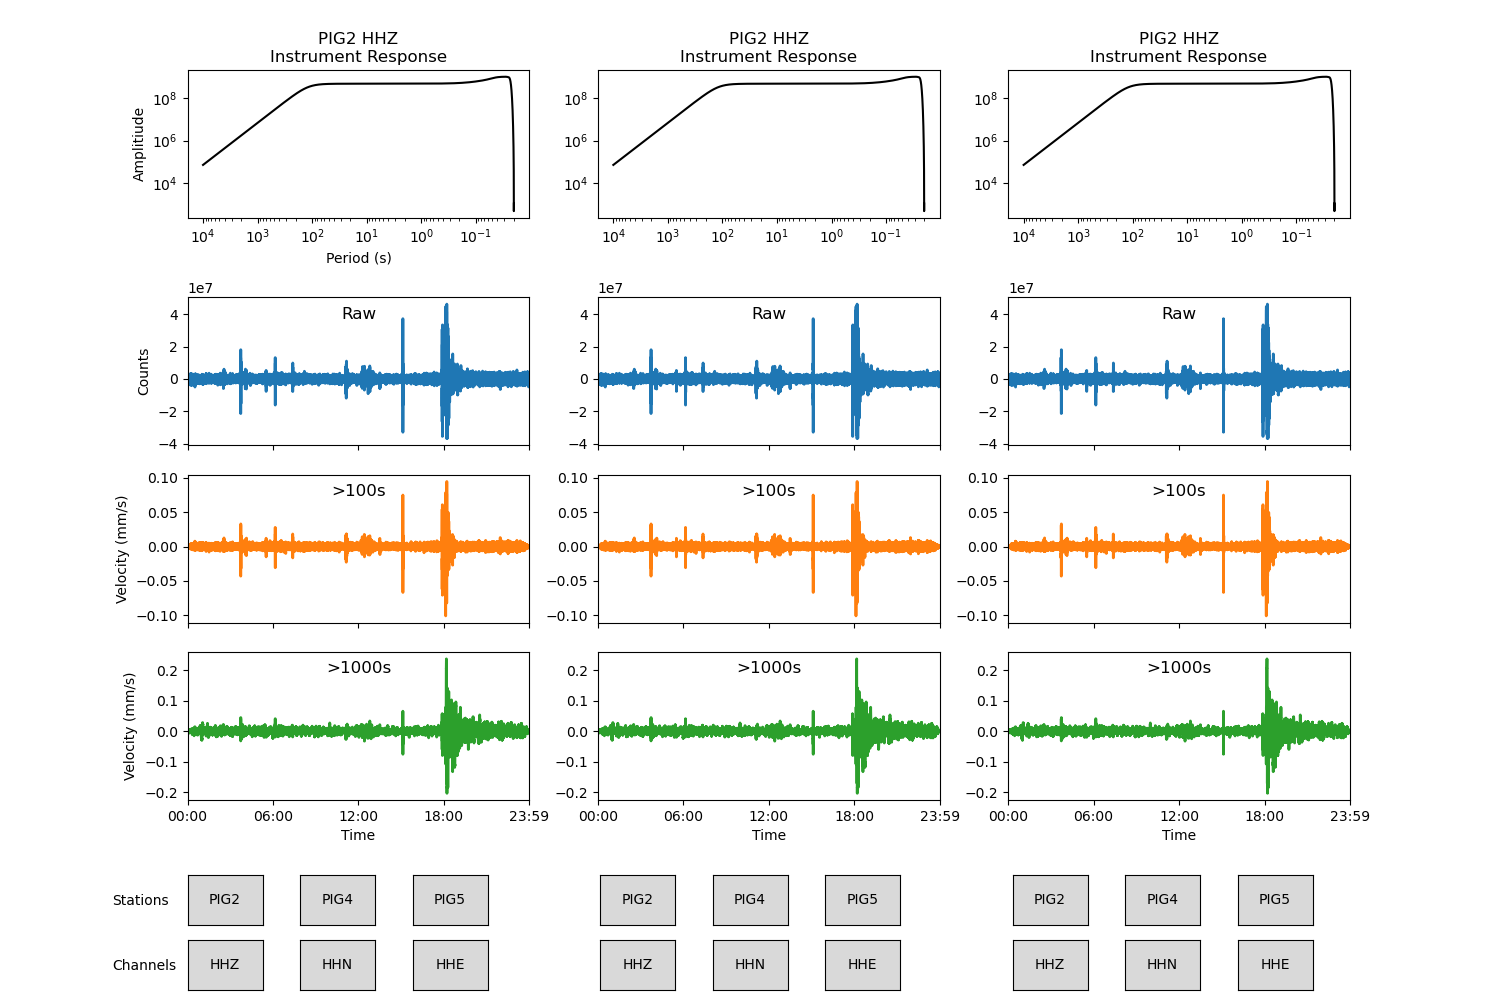

In [7]:
# get data
trace_length = 86400
t = st_raw[1].times(type="matplotlib")[:trace_length]
data_raw = st_raw.select(station="PIG2",channel="HHZ")[0].data[:trace_length]*1000
data_100s = st_100s.select(station="PIG2",channel="HHZ")[0].data[:trace_length]*1000
data_1000s = st_1000s.select(station="PIG2",channel="HHZ")[0].data[:trace_length]*1000

# make plot
fig,ax = plt.subplots(4,3,figsize=[15,10])
plt.subplots_adjust(bottom=0.2)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

# plot the data
for axis in ax[1]:
    axis.plot(t,data_raw, lw=2,color=colors[0])
    axis.set_title("Raw",y=0.8)
for axis in ax[2]:
    axis.plot(t,data_100s, lw=2,color=colors[1])
    axis.set_title(">100s",y=0.8)
for axis in ax[3]:
    axis.plot(t,data_1000s, lw=2,color=colors[2])
    axis.set_title(">1000s",y=0.8)

# plot instrumental response
sampling_rate = 100
min_freq = 0.0001
t_samp = 1.0 / sampling_rate
nyquist = sampling_rate / 2.0
nfft = int(sampling_rate / min_freq)
response = inv.select(channel="HHZ",station="PIG2")[0][0][0].response
cpx_response, freq = response.get_evalresp_response(t_samp=t_samp, nfft=nfft)
for axis in ax[0]:
    plot_resp, = axis.loglog(1/freq,abs(cpx_response),'k')
    axis.set(title="PIG2 HHZ\nInstrument Response")
    axis.invert_xaxis()

# make instances of the widget
column0 = metadata()
column1 = metadata()
column2 = metadata()

# configure labels and limits
ax[0][0].set_ylabel("Amplitiude")
ax[0][0].set_xlabel("Period (s)")
ax[1][0].set_ylabel("Counts")
ax[2][0].set_ylabel("Velocity (mm/s)")
ax[3][0].set_ylabel("Velocity (mm/s)")
for i in range(1,4):
    for axis in ax[i]:
        axis.get_xaxis().set_ticklabels([])
        axis.set_xticks([t[0],t[len(t)//4],t[len(t)//2],t[len(t)*3//4],t[-1]])
        axis.set_xlim([t[0],t[-1]])
        if i == 3:
            axis.set_xlabel("Time")
            axis.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
for i in range(3):
    box = ax[0][i].get_position()
    box.y0 = box.y0 + 0.05
    box.y1 = box.y1 + 0.05
    ax[0][i].set_position(box)
    ax[3][i].get_shared_x_axes().join(ax[3][i],ax[1][i])
    ax[3][i].get_shared_x_axes().join(ax[3][i],ax[2][i])
    
# add each set of buttons
axbutton = plt.axes([0.125, 0.075, 0.05, 0.05])
pig2_b0 = Button(axbutton, 'PIG2')
pig2_b0.on_clicked(column0.select_station("PIG2",0))
axbutton = plt.axes([0.2, 0.075, 0.05, 0.05])
pig4_b0 = Button(axbutton, 'PIG4')
pig4_b0.on_clicked(column0.select_station("PIG4",0))
axbutton = plt.axes([0.275, 0.075, 0.05, 0.05])
pig5_b0 = Button(axbutton, 'PIG5')
pig5_b0.on_clicked(column0.select_station("PIG5",0))
plt.text(-4,0.4,"Stations")
axbutton = plt.axes([0.125, 0.01, 0.05, 0.05])
hhz_b0 = Button(axbutton, 'HHZ')
hhz_b0.on_clicked(column0.select_channel("HHZ",0))
axbutton = plt.axes([0.2, 0.01, 0.05, 0.05])
hhn_b0 = Button(axbutton, 'HHN')
hhn_b0.on_clicked(column0.select_channel("HHN",0))
axbutton = plt.axes([0.275, 0.01, 0.05, 0.05])
hhe_b0 = Button(axbutton, 'HHE')
hhe_b0.on_clicked(column0.select_channel("HHE",0))
plt.text(-4,0.4,"Channels")

# second set of buttons
axbutton = plt.axes([0.125+0.275, 0.075, 0.05, 0.05])
pig2_b1 = Button(axbutton, 'PIG2')
pig2_b1.on_clicked(column1.select_station("PIG2",1))
axbutton = plt.axes([0.2+0.275, 0.075, 0.05, 0.05])
pig4_b1 = Button(axbutton, 'PIG4')
pig4_b1.on_clicked(column1.select_station("PIG4",1))
axbutton = plt.axes([0.275+0.275, 0.075, 0.05, 0.05])
pig5_b1 = Button(axbutton, 'PIG5')
pig5_b1.on_clicked(column1.select_station("PIG5",1))
axbutton = plt.axes([0.125+0.275, 0.01, 0.05, 0.05])
hhz_b1 = Button(axbutton, 'HHZ')
hhz_b1.on_clicked(column1.select_channel("HHZ",1))
axbutton = plt.axes([0.2+0.275, 0.01, 0.05, 0.05])
hhn_b1 = Button(axbutton, 'HHN')
hhn_b1.on_clicked(column1.select_channel("HHN",1))
axbutton = plt.axes([0.275+0.275, 0.01, 0.05, 0.05])
hhe_b1 = Button(axbutton, 'HHE')
hhe_b1.on_clicked(column1.select_channel("HHE",1))

# third set of buttons
axbutton = plt.axes([0.125+2*(0.275), 0.075, 0.05, 0.05])
pig2_b2 = Button(axbutton, 'PIG2')
pig2_b2.on_clicked(column2.select_station("PIG2",2))
axbutton = plt.axes([0.2+2*(0.275), 0.075, 0.05, 0.05])
pig4_b2 = Button(axbutton, 'PIG4')
pig4_b2.on_clicked(column2.select_station("PIG4",2))
axbutton = plt.axes([0.275+2*(0.275), 0.075, 0.05, 0.05])
pig5_b2 = Button(axbutton, 'PIG5')
pig5_b2.on_clicked(column2.select_station("PIG5",2))
axbutton = plt.axes([0.125+2*(0.275), 0.01, 0.05, 0.05])
hhz_b2 = Button(axbutton, 'HHZ')
hhz_b2.on_clicked(column2.select_channel("HHZ",2))
axbutton = plt.axes([0.2+2*(0.275), 0.01, 0.05, 0.05])
hhn_b2 = Button(axbutton, 'HHN')
hhn_b2.on_clicked(column2.select_channel("HHN",2))
axbutton = plt.axes([0.275+2*(0.275), 0.01, 0.05, 0.05])
hhe_b2 = Button(axbutton, 'HHE')
hhe_b2.on_clicked(column2.select_channel("HHE",2))

plt.show()

/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log10
/opt/anaconda3/envs/obspy/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


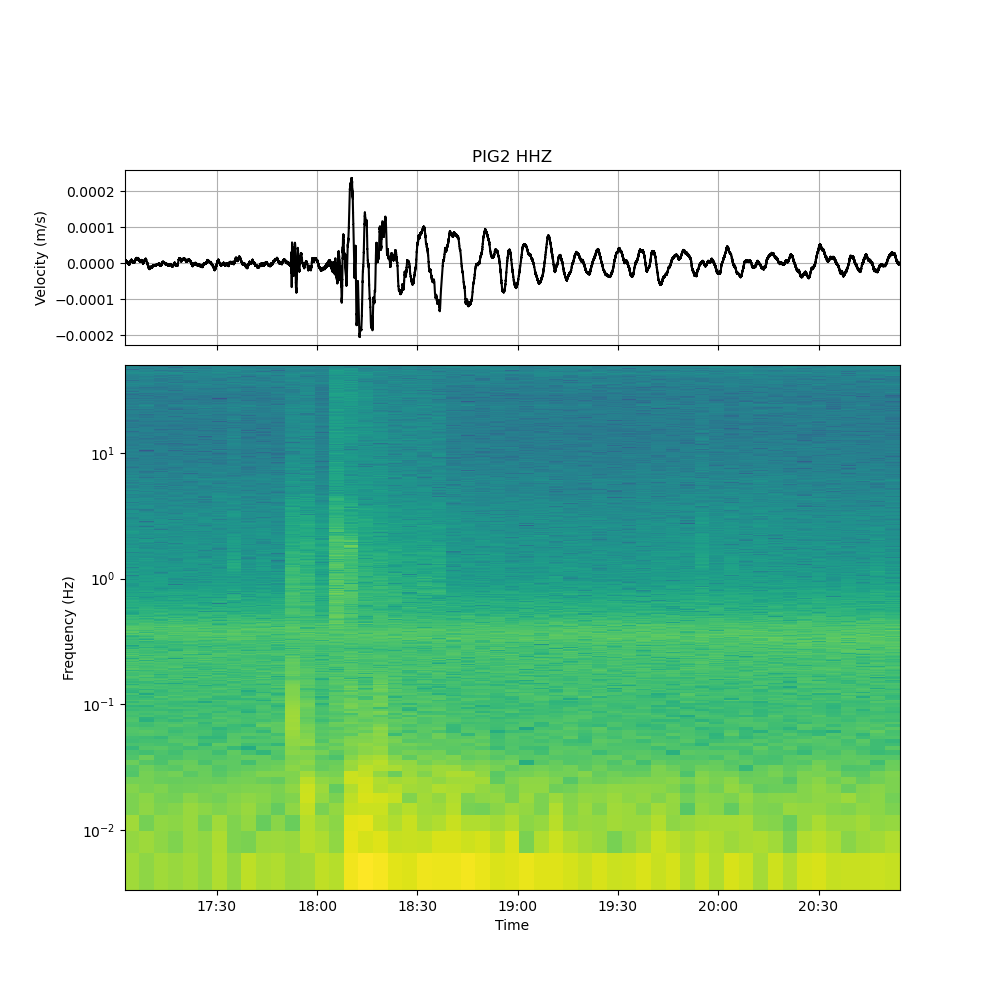

In [8]:
# set parameters
station = "PIG2"
channel = "HHZ"

# make spectrogram
st_1000s = obspy.read("data/may_9_velocity_1000s.MSEED")
st_1000s = st_1000s.trim(starttime=obspy.UTCDateTime(2012,5,9,17),endtime=obspy.UTCDateTime(2012,5,9,21))
f,t,s = spectrogram(st_1000s.select(station=station,channel=channel)[0].data, fs=100.0, nperseg=30000)

# make plot
fig,ax = plt.subplots(2,1,figsize=[10,10],gridspec_kw={'height_ratios': [1, 3]})

# plot data
times = [t.datetime for t in st_1000s[2].times("UTCDateTime")]
ticks = [times[len(times)//8],times[len(times)//4],times[len(times)//8*3],times[len(times)//2],times[len(times)//8*5],times[len(times)//4*3],times[len(times)//8*7],times[len(times)-1]]
ax[0].plot(times,st_1000s.select(channel=channel,station=station)[0].data,'k')
ax[0].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[0].get_xaxis().set_ticklabels([])
ax[0].grid(True)
box = ax[0].get_position()
box.y0 = box.y0 - 0.05
box.y1 = box.y1 - 0.05
ax[0].set_position(box)
ax[0].set_ylabel("Velocity (m/s)")    
ax[0].set_title(station+" "+channel)

# plot spectrogram 
times = [datetime.datetime(2012,5,9,17) + datetime.timedelta(seconds=time) for time in t]
ax[1].pcolor(times, np.log10(f), s, norm=LogNorm())
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax[1].get_shared_x_axes().join(ax[0],ax[1])
ax[1].set_xticks(ticks)
ax[1].set_xlim([times[0],times[-1]])
ax[1].set_yticks([-2,-1,0,1])
ax[1].set_yticklabels(["$10^{-2}$","$10^{-1}$","$10^{0}$","$10^{1}$"])
ax[1].set_ylabel("Frequency (Hz)")
ax[1].set_xlabel("Time")
plt.show()